In [5]:
import torch
from torch import optim
from torch.utils.data import DataLoader
from torchvision import transforms

from PIL import Image
import matplotlib.pyplot as plt
import random

from src.dataset.mydataset import LicensePlatesDataset
from src.dataset.transforms import MotionBlurTransform
from src.train.trainer import train

from src.models.model_builder import ModelBuilder
from src.utils.data_utils import label_to_string
from src.utils.pred_utils import predict_code
from src.train.early_stopping import EarlyStopping

TRAIN = True
device = 'cpu'


#### **Dataset**

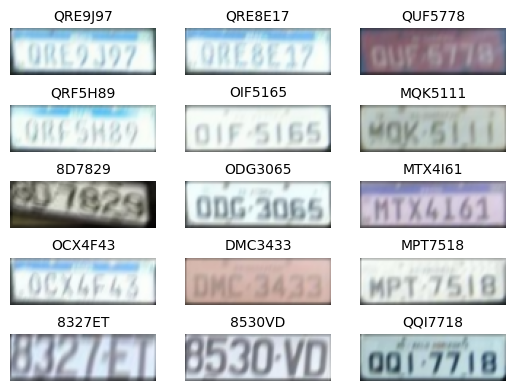

In [43]:
# Define directories and parametrs
data_dir = './data/LPDataset/'
csv_file = './data/LPDataset/image_info.csv'
batch_size = 64
max_len = 12

# Define transformation
transform = transforms.Compose([
    MotionBlurTransform(random.randrange(3, 12, step=2), random.uniform(-225, -45), random.uniform(-1, 1)),         # Motion blur
    transforms.Resize((32, 100)),                                                                                   # Resize
    transforms.ToTensor()                                                                                           # To tensor
])

# Build datasets
train_dataset = LicensePlatesDataset(root_dir=data_dir, csv_file=csv_file, max_len=max_len, split='train', transform=transform)
test_dataset = LicensePlatesDataset(root_dir=data_dir, csv_file=csv_file, max_len=max_len, split='test', transform=transform)
valid_dataset = LicensePlatesDataset(root_dir=data_dir, csv_file=csv_file, max_len=max_len, split='valid', transform=transform)

# Build dataloadters
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# Define set of datasets
datasets = [train_dataset, test_dataset, valid_dataset]

# Define plot
fig, axes = plt.subplots(5, 3)

# Plot random samples
for i in range(5):
    for j in range(len(datasets)):
        # Define random index
        r_idx = random.randint(0, len(datasets[j]))
        # Extract data from dataset
        image, label, label_len = datasets[j][r_idx][0], datasets[j][r_idx][1], datasets[j][r_idx][2]
        # Plot image
        axes[i, j].imshow(image.numpy().transpose(1,2,0))
        axes[i, j].set_title(label_to_string(label), fontsize=10)
        axes[i, j].axis('off')

plt.show()

#### **Model**

In [3]:
# Define the model
model = ModelBuilder(
    rec_num_classes=len(test_dataset.char2id),
    max_len_labels=max_len,
    eos=test_dataset.char2id[test_dataset.EOS]
)

# Load weights
checkpoint = torch.load('./weights/demo.pth.tar', map_location=device)
model.load_state_dict(checkpoint['state_dict'])

# Move the model to device
model.to(device)

print('Loaded weights')

Loaded weights


#### **Training**

In [4]:
# Define params
num_epochs = 1
grad_clip = -1
loss_weights = { 'loss_rec': 1 }

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
# Define early stopping
early_stop = EarlyStopping(model=model, eps=1e-5, threshold=10, savePath=f"./weights/ANPRv1_backup_{num_epochs}ep_test.pth.tar")

# Train model
if TRAIN:
    train(model=model, optimizer=optimizer, es=early_stop, train_loader=train_loader, valid_loader=valid_loader, num_epochs=num_epochs, loss_weights=loss_weights, grad_clip=grad_clip, device=device)

Epoch [1/1] Batch [0/97], Train Loss: 1.7956
Epoch [1/1] Batch [20/97], Train Loss: 0.4977
Epoch [1/1] Batch [40/97], Train Loss: 0.2258


KeyboardInterrupt: 

#### **Testing**

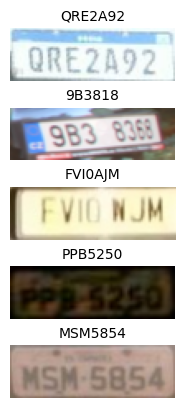

In [ ]:
# Load weights
checkpoint = torch.load('./weights/mod1/modellov1_92acc.tar', map_location=device)
model.load_state_dict(checkpoint)

# Set the model to evaluation mode
model.eval()

# Define plot
fig, axes = plt.subplots(5, 1)

# For 5 times
for i in range(5):
    # Define random index
    r_idx = random.randint(0, len(test_dataset))
    # Extract r_idx-th element of the dataset
    image, label , label_len = test_dataset[r_idx][0], test_dataset[r_idx][1], test_dataset[r_idx][2]
    # Predict label
    pred_rec = model((image.unsqueeze(0), label.unsqueeze(0), label_len.unsqueeze(0)))['output']['pred_rec'][0]
    # Convert predicted label to string
    predicted_string = label_to_string(pred_rec)
    # Plot image
    axes[i].imshow(image.numpy().transpose(1,2,0))
    axes[i].set_title(f'{predicted_string}', fontsize=10)
    axes[i].axis('off')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Increase or decrease wspace and hspace as needed
plt.show()   

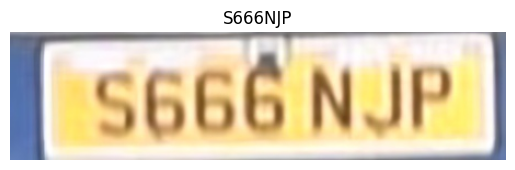

In [ ]:
import os
import pandas as pd

# Define image path
img_path = './data/LPDataset/customLP/S666NJP.jpg'
# Open image
image = Image.open(img_path)
# Plot result
plt.imshow(image)
plt.title(predict_code(model, image, max_len, test_dataset.char2id[test_dataset.EOS], transform, device))
plt.axis('off')
plt.show()